### Imports

In [1]:
import os
import sys
src_path = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'src'))
sys.path.append(src_path)
import chess
import json
import chess.svg
from IPython.display import SVG, display, clear_output
from chess_zero.config import Config, PlayWithHumanConfig
from chess_zero.agent.model_chess import ChessModel
from chess_zero.agent.player_chess import ChessPlayer
import numpy as np
from chess_zero.env.chess_env import ChessEnv
from chess_zero.agent.model_chess import ChessModel
from chess_zero.lib.model_helper import load_best_model_weight

2024-09-25 22:28:18.008622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 22:28:18.019812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 22:28:18.022952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 22:28:18.031885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 22:28:18.692241: W tensorflow/compiler/tf2

### Play the model


In [ ]:

# Play the model against a human
def get_player(config):
    model = ChessModel(config)
    if not load_best_model_weight(model):
        raise RuntimeError("Best model not found!")
    return ChessPlayer(config, model.get_pipes(config.play.search_threads))

def display_board(board):
    clear_output(wait=True)
    display(SVG(chess.svg.board(board=board, size=400)))

def play_game():
    default_config = Config()
    PlayWithHumanConfig().update_play_config(default_config.play)
    ai_player = get_player(default_config)
    env = ChessEnv().reset()

    while not env.done:
        display_board(env.board)
        
        if env.board.turn == chess.WHITE:  # Human plays as White
            while True:
                try:
                    move = input("Enter your move (e.g., e2e4): ")
                    env.step(move)  # Pass the string directly
                    break
                except ValueError:
                    print("Invalid move. Try again.")
        else:  # AI plays as Black
            action = ai_player.action(env, False)
            print(f"AI move: {action}")
            env.step(action)
    
    display_board(env.board)
    print("Game Over")
    print(f"Result: {env.board.result()}")

# Run the game`
play_game()

### Compare two models to see how they play against each other

Compare the two models in the model_comp folder.
- Model A is in the model_comp/model_a folder.
- Model B is in the model_comp/model_b folder.

#### Load the models and double check that they are not duplicates

In [2]:
import numpy as np
from tensorflow.keras.models import Model

config = Config()

def load_specific_model(model, config_path, weight_path):
    """
    Load a specific model from given paths
    """
    if os.path.exists(config_path) and os.path.exists(weight_path):
        with open(config_path, "rt") as f:
            model.model = Model.from_config(json.load(f))
        print(f"Model summary for {weight_path}:")
        model.model.summary()
        try:
            # Try to load the weights file
            model.model.load_weights(weight_path)
            print(f"Weights loaded successfully from {weight_path}")
            return True
        except Exception as e:
            print(f"Error loading weights: {str(e)}")
            return False
    else:
        print(f"Model files not found at {config_path} or {weight_path}")
        return False

# Paths for model A and B
model_a_path = '/home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_A'
model_b_path = '/home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_B'


# Create model instances
model_a = ChessModel(config)
model_b = ChessModel(config)

# Load the specific models
load_specific_model(model_a, 
                    os.path.join(model_a_path, 'model_best_config.json'),
                    os.path.join(model_a_path, 'model_best.weights.h5'))

load_specific_model(model_b, 
                    os.path.join(model_b_path, 'model_best_config.json'),
                    os.path.join(model_b_path, 'model_best_weight.h5'))

# Print the locations of the loaded models
print("Model A config:", os.path.join(model_a_path, 'model_best_config.json'))
print("Model A weights:", os.path.join(model_a_path, 'model_best.weights.h5'))
print("Model B config:", os.path.join(model_b_path, 'model_best_config.json'))
print("Model B weights:", os.path.join(model_b_path, 'model_best_weight.h5'))

def models_are_equal(model_a, model_b):
    weights_a = model_a.model.get_weights()
    weights_b = model_b.model.get_weights()
    
    if len(weights_a) != len(weights_b):
        return False
    
    return all(np.array_equal(w_a, w_b) for w_a, w_b in zip(weights_a, weights_b))

if models_are_equal(model_a, model_b):
    print("The models are duplicates")
else:
    print("The models are not duplicates")


I0000 00:00:1727321300.769580  263634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727321300.791283  263634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727321300.791337  263634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727321300.795855  263634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727321300.795909  263634 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model summary for /home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_A/model_best.weights.h5:


Model: "chess_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 18, 8, 8)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_conv-5-256    │ (None, 256, 8, 8) │    115,200 │ input_layer[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_batchnorm     │ (None, 256, 8, 8) │      1,024 │ input_conv-5-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_relu          │ (None, 256, 8, 8) │          0 │ input_batchnorm[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_conv1-3-256    │ (None, 256, 8, 8) │    589,824 │ input_relu[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_batchnorm1     │ (None, 256, 8, 8) │      1,024 │ res1_conv1-3-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_relu1          │ (None, 256, 8, 8) │          0 │ res1_batchnorm1[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_conv2-3-256    │ (None, 256, 8, 8) │    589,824 │ res1_relu1[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_batchnorm2     │ (None, 256, 8, 8) │      1,024 │ res1_conv2-3-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_add (Add)      │ (None, 256, 8, 8) │          0 │ input_relu[0][0], │
│                     │                   │            │ res1_batchnorm2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_relu2          │ (None, 256, 8, 8) │          0 │ res1_add[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_conv1-3-256    │ (None, 256, 8, 8) │    589,824 │ res1_relu2[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_batchnorm1     │ (None, 256, 8, 8) │      1,024 │ res2_conv1-3-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_relu1          │ (None, 256, 8, 8) │          0 │ res2_batchnorm1[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_conv2-3-256    │ (None, 256, 8, 8) │    589,824 │ res2_relu1[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_batchnorm2     │ (None, 256, 8, 8) │      1,024 │ res2_conv2-3-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_add (Add)      │ (None, 256, 8, 8) │          0 │ res1_relu2[0][0]

 Total params: 8,709,577 (33.22 MB)

 Trainable params: 8,701,885 (33.20 MB)

 Non-trainable params: 7,692 (30.05 KB)

Weights loaded successfully from /home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_A/model_best.weights.h5
Model summary for /home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_B/model_best_weight.h5:


Model: "chess_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 18, 8, 8)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_conv-3-256    │ (None, 256, 8, 8) │     41,472 │ input_1[0][0]     │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_batchnorm     │ (None, 256, 8, 8) │         32 │ input_conv-3-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_relu          │ (None, 256, 8, 8) │          0 │ input_batchnorm[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_conv1-3-256    │ (None, 256, 8, 8) │    589,824 │ input_relu[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_batchnorm1     │ (None, 256, 8, 8) │         32 │ res1_conv1-3-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_relu1          │ (None, 256, 8, 8) │          0 │ res1_batchnorm1[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_conv2-3-256    │ (None, 256, 8, 8) │    589,824 │ res1_relu1[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_batchnorm2     │ (None, 256, 8, 8) │         32 │ res1_conv2-3-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_add (Add)      │ (None, 256, 8, 8) │          0 │ input_relu[0][0], │
│                     │                   │            │ res1_batchnorm2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_relu2          │ (None, 256, 8, 8) │          0 │ res1_add[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_conv1-3-256    │ (None, 256, 8, 8) │    589,824 │ res1_relu2[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_batchnorm1     │ (None, 256, 8, 8) │         32 │ res2_conv1-3-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_relu1          │ (None, 256, 8, 8) │          0 │ res2_batchnorm1[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_conv2-3-256    │ (None, 256, 8, 8) │    589,824 │ res2_relu1[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_batchnorm2     │ (None, 256, 8, 8) │         32 │ res2_conv2-3-256… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_add (Add)      │ (None, 256, 8, 8) │          0 │ res1_relu2[0][0]

 Total params: 8,571,089 (32.70 MB)

 Trainable params: 8,570,817 (32.70 MB)

 Non-trainable params: 272 (1.06 KB)

Error loading weights: The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(8,), Received: value.shape=(256,). Target variable: <KerasVariable shape=(8,), dtype=float32, path=input_batchnorm/gamma>
Model A config: /home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_A/model_best_config.json
Model A weights: /home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_A/model_best.weights.h5
Model B config: /home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_B/model_best_config.json
Model B weights: /home/cale_admin/ChessEngine/alphazero/notebooks/model_comp/model_B/model_best_weight.h5
The models are not duplicates


#### Showtime

In [ ]:
def setup_players(model_a, model_b, config):
    pipes_a = model_a.get_pipes(config.play.search_threads)
    pipes_b = model_b.get_pipes(config.play.search_threads)
    player_a = ChessPlayer(config, pipes=pipes_a)
    player_b = ChessPlayer(config, pipes=pipes_b)
    return player_a, player_b

def display_board(board):
    clear_output(wait=True)
    display(SVG(chess.svg.board(board=board, size=400)))
    
    
def play_game(player_a, player_b, env):
    env.reset()
    done = False
    move_count = 0
    while not done:
        display_board(env.board)
        if env.white_to_move:
            print("Model A is thinking...")
            action = player_a.action(env)
            player = "Model A"
        else:
            print("Model B is thinking...")
            action = player_b.action(env)
            player = "Model B"
        print(f"Move {move_count + 1}: {player} plays {action}")
        env.step(action)
        done = env.done
        move_count += 1
        if move_count > 250:  # Add a move limit to prevent infinite games
            print("Game exceeded 250 moves, ending in a draw.")
            return 0
    display_board(env.board)
    return env.winner

def compare_models(model_a, model_b, config, num_games=5):
    player_a, player_b = setup_players(model_a, model_b, config)
    env = ChessEnv()
    results = {'model_a_wins': 0, 'model_b_wins': 0, 'draws': 0}
    
    for game in range(num_games):
        print(f"\nGame {game + 1}")
        try:
            winner = play_game(player_a, player_b, env)
            if winner == 1:
                results['model_a_wins'] += 1
                print("Model A wins!")
            elif winner == -1:
                results['model_b_wins'] += 1
                print("Model B wins!")
            else:
                results['draws'] += 1
                print("It's a draw!")
        except Exception as e:
            print(f"Error in game {game + 1}: {str(e)}")
            break
        
        # Switch sides
        player_a, player_b = player_b, player_a
    
    return results

# Assuming you've already loaded model_a and model_b
config = Config()
results = compare_models(model_a, model_b, config, num_games=1)

print(f"\nFinal Results:")
print(f"Model A wins: {results['model_a_wins']}")
print(f"Model B wins: {results['model_b_wins']}")
print(f"Draws: {results['draws']}")

####  Stockfish vs AlphaZero

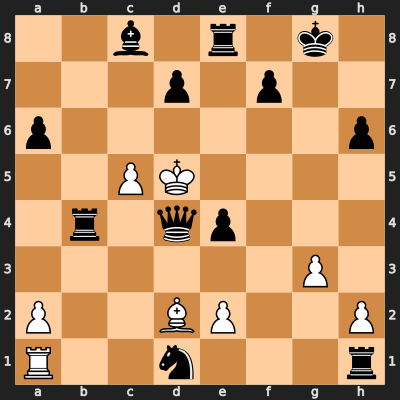

Stockfish wins by checkmate in 60 moves!
Final position: 2b1r1k1/3p1p2/p6p/2PK4/1r1qp3/6P1/P2BP2P/R2n3r w - - 7 31

Final Results:
AlphaZero wins: 0
Stockfish wins: 1
Draws: 0
Total moves: 60


In [3]:
from stockfish import Stockfish
import chess
import chess.svg
from IPython.display import SVG, display, clear_output
import time


def setup_player(model, config):
    pipes = model.get_pipes(config.play.search_threads)
    player = ChessPlayer(config, pipes=pipes)
    return player

def get_stockfish_move(stockfish, time_limit=1.0):
    best_move = stockfish.get_top_moves(3)[2]['Move']
    print(best_move)
    # best_move = stockfish.get_best_move_time(int(time_limit * 1000))
    return best_move

def display_board(board):
    clear_output(wait=True)
    display(SVG(chess.svg.board(board=board, size=400)))

def play_game(alpha_zero_player, stockfish, env, time_limit=1.0):
    env.reset()
    done = False
    move_count = 0
    while not done:
        display_board(env.board)
        if env.white_to_move:
            print("AlphaZero is thinking...")
            action = alpha_zero_player.action(env)
            player = "AlphaZero"
        else:
            print("Stockfish is thinking...")
            stockfish.set_fen_position(env.board.fen())
            action = get_stockfish_move(stockfish, time_limit)
            player = "Stockfish"
        print(f"Move {move_count + 1}: {player} plays {action}")
        try:
            env.step(action)
        except ValueError as e:
            print(f"Invalid move: {action}. Error: {str(e)}")
            return (1 if player == "Stockfish" else -1), move_count  # The other player wins due to invalid move
        move_count += 1
        
        # Check for game-ending conditions
        if env.board.is_checkmate():
            display_board(env.board)
            return (-1 if env.white_to_move else 1), move_count  # The player who just moved wins
        elif env.board.is_stalemate() or env.board.is_insufficient_material() or env.board.is_fifty_moves() or env.board.is_repetition():
            print("Game is a draw by rule")
            time.sleep(5)
            display_board(env.board)
            return 0, move_count  # Draw
        elif move_count > 250:
            print("Game exceeded 250 moves, ending in a draw.")
            return 0, move_count
        
        time.sleep(1)  # Add a delay to make it easier to follow the game
    
    # This should not be reached, but just in case
    display_board(env.board)
    return env.winner, move_count

def play_alphazero_vs_stockfish(model_a, config, num_games=1, time_limit=1.0):
    alpha_zero_player = setup_player(model_a, config)
    env = ChessEnv()
    results = {'alpha_zero_wins': 0, 'stockfish_wins': 0, 'draws': 0, 'total_moves': 0}
    
    stockfish = Stockfish(path="/usr/games/stockfish")
    
    for game in range(num_games):
        print(f"\nGame {game + 1}")
        try:
            if game % 2 == 0:
                winner, moves = play_game(alpha_zero_player, stockfish, env, time_limit)
            else:
                winner, moves = play_game(stockfish, alpha_zero_player, env, time_limit)
                winner = -winner  # Invert the winner since AlphaZero is playing black
            
            results['total_moves'] += moves
            if winner == 1:
                results['alpha_zero_wins'] += 1
                print(f"AlphaZero wins by checkmate in {moves} moves!")
            elif winner == -1:
                results['stockfish_wins'] += 1
                print(f"Stockfish wins by checkmate in {moves} moves!")
            else:
                results['draws'] += 1
                print(f"It's a draw after {moves} moves!")
            print(f"Final position: {env.board.fen()}")
            time.sleep(5)
        except Exception as e:
            print(f"Error in game {game + 1}: {str(e)}")
            break
    
    return results

# Run the game
config = Config()
results = play_alphazero_vs_stockfish(model_a, config, num_games=1, time_limit=1.0)

print(f"\nFinal Results:")
print(f"AlphaZero wins: {results['alpha_zero_wins']}")
print(f"Stockfish wins: {results['stockfish_wins']}")
print(f"Draws: {results['draws']}")
print(f"Total moves: {results['total_moves']}")
# print(f"Average moves per game: {results['total_moves'] / (results['alpha_zero_wins'] + results['stockfish_wins'] + results['draws']):.2f}")